In [1]:
import sys
import os
# Agrega la raíz del proyecto al path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [ ]:
# Entrenamiento Multimodal
# 0) Imports y configuración
import os
import warnings
import gc
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from torchvision.models import ResNet18_Weights
from torch.cuda.amp import autocast, GradScaler
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tqdm.notebook import tqdm

# Importación librerías personalizadas

from scripts.dataset_miltimodal import FishDataset
from scripts.modelo_multimodal import MultiModalNet

In [3]:
# 1) Suprimir warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# 2) Leer CSV normalizado y filtrar imágnes existentes (sin print)
label_csv    = "../data/labels2_kmeans_limpio.csv"
preproc_dir  = "../data/images_preproc"
df_all       = pd.read_csv(label_csv)

# Quedarnos sólo con las filas cuyo archivo preproc existe
# Nos quedamos sólo con las filas cuyo archivo existe en su carpeta de clase
mask_exists = df_all.apply(
    lambda r: os.path.isfile(os.path.join(preproc_dir, str(r['etiqueta_kmeans']), r['imagen'])),
    axis=1
)
df = df_all[mask_exists].reset_index(drop=True)
print(f"Usando {len(df)}/{len(df_all)} imágenes preprocesadas disponibles")

Usando 14184/14185 imágenes preprocesadas disponibles


In [5]:
# 3) Parte en train/validation split estratificado
train_df, val_df = train_test_split(
    df, 
    test_size=0.2,
    stratify=df['etiqueta_kmeans'],
    random_state=42
)

In [6]:
# Seleccionamos las columnas
sensor_cols = ['temperatura','pH','conductividad','TDS','DO_mgL']

# Forzamos todos los valores a float, los no convertibles pasan a NaN
df[sensor_cols] = df[sensor_cols].apply(pd.to_numeric, errors='coerce')

# Eliminamos cualquier fila que tenga NaN en *cualquiera* de las columnas de sensores
n0 = len(df)
df = df.dropna(subset=sensor_cols).reset_index(drop=True)
n1 = len(df)
print(f"Descartadas {n0-n1} filas sin datos numéricos en sensores; quedan {n1} filas")


Descartadas 0 filas sin datos numéricos en sensores; quedan 14184 filas


In [ ]:
# Mapas de clases e índices
counts = train_df['etiqueta_kmeans'].value_counts()
total  = len(train_df)
sample_weights = train_df['etiqueta_kmeans'].map(lambda x: total/counts[x]).values
sampler = WeightedRandomSampler(sample_weights, 
                                num_samples=total, 
                                replacement=True)

In [ ]:
# Transforms y DataLoader
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_ds = FishDataset(train_df, preproc_dir, sensor_cols, transform)
val_ds   = FishDataset(val_df, preproc_dir, sensor_cols, transform)

batch_size = 16

# Ponemos num_wonkers=0 para desactivar multiprocesamiento
train_loader = DataLoader(
    train_ds, 
    batch_size=batch_size, 
    sampler=sampler, 
    num_workers=0,
    pin_memory=False
)
val_loader = DataLoader(
    val_ds, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=0,
    pin_memory=False
)

In [ ]:
# 7) Definir modelo multimodal (ResNet18 + MLP)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultiModalNet(sensor_dim=len(sensor_cols), n_classes=3).to(device)

# 8) Loss y optimizer
class_weights = torch.tensor([total/counts[c] for c in ['enfermo','estres_leve','saludable']],
                             dtype=torch.float32, device=device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [10]:
# 9) Entrenamiento con tqdm y AMP

best_val_loss = float('inf')

scaler = GradScaler()
num_epochs = 10
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(1, num_epochs+1):
    # Entrenamiento
    model.train()
    rloss, corr, total = 0.0, 0, 0
    train_iter = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [Train]", leave=False)
    for imgs, sens, labs in train_iter:
        imgs, sens, labs = imgs.to(device), sens.to(device), labs.to(device)
        optimizer.zero_grad()
        with autocast():
            outputs = model(imgs, sens)
            loss = criterion(outputs, labs)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        rloss += loss.item()*labs.size(0)
        preds = outputs.argmax(1)
        corr += (preds==labs).sum().item()
        total += labs.size(0)
        train_iter.set_postfix(loss=f"{loss.item():.4f}", acc=f"{corr/total:.3f}")

    train_losses.append(rloss/total)
    train_accs.append(corr/total)

    # Validación
    model.eval()
    rloss, corr, total = 0.0, 0, 0
    val_iter = tqdm(val_loader, desc=f"Epoch {epoch}/{num_epochs} [ Val ]", leave=False)
    with torch.no_grad():
        for imgs, sens, labs in val_iter:
            imgs, sens, labs = imgs.to(device), sens.to(device), labs.to(device)
            with autocast():
                outputs = model(imgs, sens)
                loss = criterion(outputs, labs)

            rloss += loss.item()*labs.size(0)
            preds = outputs.argmax(1)
            corr += (preds==labs).sum().item()
            total += labs.size(0)
            val_iter.set_postfix(loss=f"{loss.item():.4f}", acc=f"{corr/total:.3f}")

    val_losses.append(rloss/total)
    val_accs.append(corr/total)

    # Al acabar validación, guardamos el modelo.
    val_loss_epoch = val_losses[-1]
    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        torch.save(model.state_dict(), 'modelos/best_model.pt')
        print(f"→ Guardado nuevo mejor modelo (val_loss={best_val_loss:.4f})")

    # Mostrar resumen
    print(f"Epoch {epoch}/{num_epochs} | "
          f"Train Loss: {train_losses[-1]:.4f}, Acc: {train_accs[-1]:.3f} | "
          f" Val Loss: {val_losses[-1]:.4f}, Acc: {val_accs[-1]:.3f}")

Epoch 1/10 [Train]:   0%|          | 0/710 [00:00<?, ?it/s]

Epoch 1/10 [ Val ]:   0%|          | 0/178 [00:00<?, ?it/s]

→ Guardado nuevo mejor modelo (val_loss=0.1800)
Epoch 1/10 | Train Loss: 0.2772, Acc: 0.886 |  Val Loss: 0.1800, Acc: 0.926


Epoch 2/10 [Train]:   0%|          | 0/710 [00:00<?, ?it/s]

Epoch 2/10 [ Val ]:   0%|          | 0/178 [00:00<?, ?it/s]

→ Guardado nuevo mejor modelo (val_loss=0.1450)
Epoch 2/10 | Train Loss: 0.1439, Acc: 0.942 |  Val Loss: 0.1450, Acc: 0.943


Epoch 3/10 [Train]:   0%|          | 0/710 [00:00<?, ?it/s]

Epoch 3/10 [ Val ]:   0%|          | 0/178 [00:00<?, ?it/s]

→ Guardado nuevo mejor modelo (val_loss=0.1208)
Epoch 3/10 | Train Loss: 0.1094, Acc: 0.957 |  Val Loss: 0.1208, Acc: 0.956


Epoch 4/10 [Train]:   0%|          | 0/710 [00:00<?, ?it/s]

Epoch 4/10 [ Val ]:   0%|          | 0/178 [00:00<?, ?it/s]

→ Guardado nuevo mejor modelo (val_loss=0.0965)
Epoch 4/10 | Train Loss: 0.0858, Acc: 0.966 |  Val Loss: 0.0965, Acc: 0.965


Epoch 5/10 [Train]:   0%|          | 0/710 [00:00<?, ?it/s]

Epoch 5/10 [ Val ]:   0%|          | 0/178 [00:00<?, ?it/s]

→ Guardado nuevo mejor modelo (val_loss=0.0884)
Epoch 5/10 | Train Loss: 0.0742, Acc: 0.971 |  Val Loss: 0.0884, Acc: 0.965


Epoch 6/10 [Train]:   0%|          | 0/710 [00:00<?, ?it/s]

Epoch 6/10 [ Val ]:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 6/10 | Train Loss: 0.0637, Acc: 0.976 |  Val Loss: 0.1086, Acc: 0.964


Epoch 7/10 [Train]:   0%|          | 0/710 [00:00<?, ?it/s]

Epoch 7/10 [ Val ]:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 7/10 | Train Loss: 0.0561, Acc: 0.978 |  Val Loss: 0.0992, Acc: 0.962


Epoch 8/10 [Train]:   0%|          | 0/710 [00:00<?, ?it/s]

Epoch 8/10 [ Val ]:   0%|          | 0/178 [00:00<?, ?it/s]

→ Guardado nuevo mejor modelo (val_loss=0.0790)
Epoch 8/10 | Train Loss: 0.0493, Acc: 0.981 |  Val Loss: 0.0790, Acc: 0.972


Epoch 9/10 [Train]:   0%|          | 0/710 [00:00<?, ?it/s]

Epoch 9/10 [ Val ]:   0%|          | 0/178 [00:00<?, ?it/s]

Epoch 9/10 | Train Loss: 0.0416, Acc: 0.987 |  Val Loss: 0.0847, Acc: 0.971


Epoch 10/10 [Train]:   0%|          | 0/710 [00:00<?, ?it/s]

Epoch 10/10 [ Val ]:   0%|          | 0/178 [00:00<?, ?it/s]

→ Guardado nuevo mejor modelo (val_loss=0.0781)
Epoch 10/10 | Train Loss: 0.0334, Acc: 0.989 |  Val Loss: 0.0781, Acc: 0.967


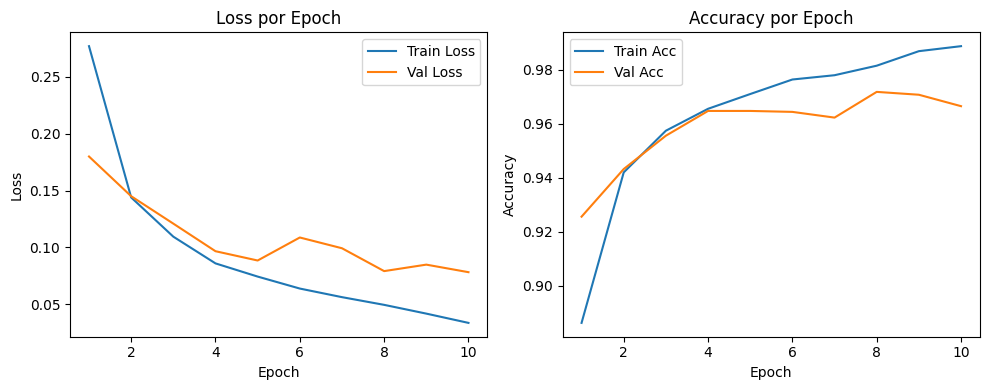

In [11]:
# 10) Gráficos de métricas
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.title('Loss por Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accs, label='Train Acc')
plt.plot(range(1, num_epochs + 1), val_accs, label='Val Acc')
plt.title('Accuracy por Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

     enfermo       1.00      1.00      1.00      1154
 estres_leve       0.90      0.97      0.93       632
   saludable       0.98      0.94      0.96      1051

    accuracy                           0.97      2837
   macro avg       0.96      0.97      0.96      2837
weighted avg       0.97      0.97      0.97      2837



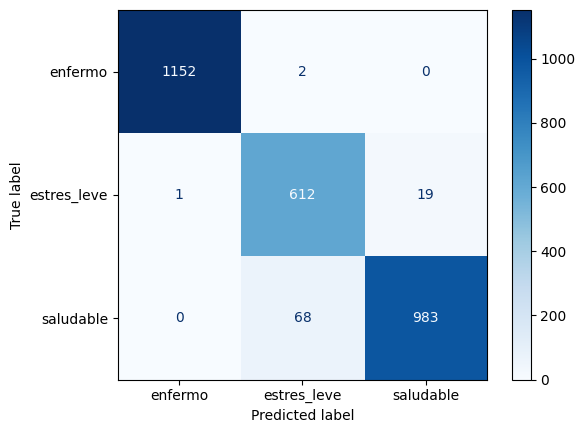

In [12]:
# 11) Reporte final y matriz de confusión
all_preds, all_labs = [], []
model.eval()
with torch.no_grad():
    for imgs, sens, labs in val_loader:
        imgs, sens = imgs.to(device), sens.to(device)
        preds = model(imgs, sens).argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labs.extend(labs.numpy())

print(classification_report(all_labs, all_preds, target_names=['enfermo','estres_leve','saludable']))
cm = confusion_matrix(all_labs, all_preds)
_ = ConfusionMatrixDisplay(cm, display_labels=['enfermo','estres_leve','saludable']).plot(cmap='Blues')
plt.show()